# Task 3.1 Unsupervised Learning - Clustering

In [6]:
# Load Dataset
import pandas as pd
import numpy as np

df = pd.read_csv("food.csv")
print(df.head())

       Unnamed: 0  RedMeat  WhiteMeat  Eggs  Milk  Fish  Cereals  Starch  \
0         Albania     10.1        1.4   0.5   8.9   0.2     42.3     0.6   
1         Austria      8.9       14.0   4.3  19.9   2.1     28.0     3.6   
2         Belgium     13.5        9.3   4.1  17.5   4.5     26.6     5.7   
3        Bulgaria      7.8        6.0   1.6   8.3   1.2     56.7     1.1   
4  Czechoslovakia      9.7       11.4   2.8  12.5   2.0     34.3     5.0   

   Nuts  Fr.Veg  
0   5.5     1.7  
1   1.3     4.3  
2   2.1     4.0  
3   3.7     4.2  
4   1.1     4.0  


In [ ]:
# check for NaNs [Note: André Schomakers showed me this cool trick ;) ]
df.isna().sum().sum() 

np.int64(0)

In [ ]:
#Extract countries fpr the plot later on
countries = df.iloc[:, 0] 
#Get an overview of the subset
countries

0            Albania
1            Austria
2            Belgium
3           Bulgaria
4     Czechoslovakia
5            Denmark
6          E Germany
7            Finland
8             France
9             Greece
10           Hungary
11           Ireland
12             Italy
13       Netherlands
14            Norway
15            Poland
16          Portugal
17           Romania
18             Spain
19            Sweden
20       Switzerland
21                UK
22              USSR
23         W Germany
24        Yugoslavia
Name: Unnamed: 0, dtype: object

In [ ]:
# Handle missing values 
df = df.dropna()  # Drop rows with missing values (for simplicity)
# Keep only numeric columns 
df_numeric = df.select_dtypes(include=[np.number])  

In [10]:
# Preprocess Data with Z-Transformation
from sklearn.preprocessing import StandardScaler


# Feature scaling (Z-transformation using StandardScaler)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

In [ ]:
#Kmeans Clustering with varyning k

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = 0
best_score = -1
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"k={k}, Silhouette Score={score}")
    if score > best_score:
        best_k = k
        best_score = score
        best_model = kmeans

# choose k=3 because of the highes Score 


k=2, Silhouette Score=0.3271084145417136
k=3, Silhouette Score=0.3351693984160507
k=4, Silhouette Score=0.2798600378321701
k=5, Silhouette Score=0.21400058012556447


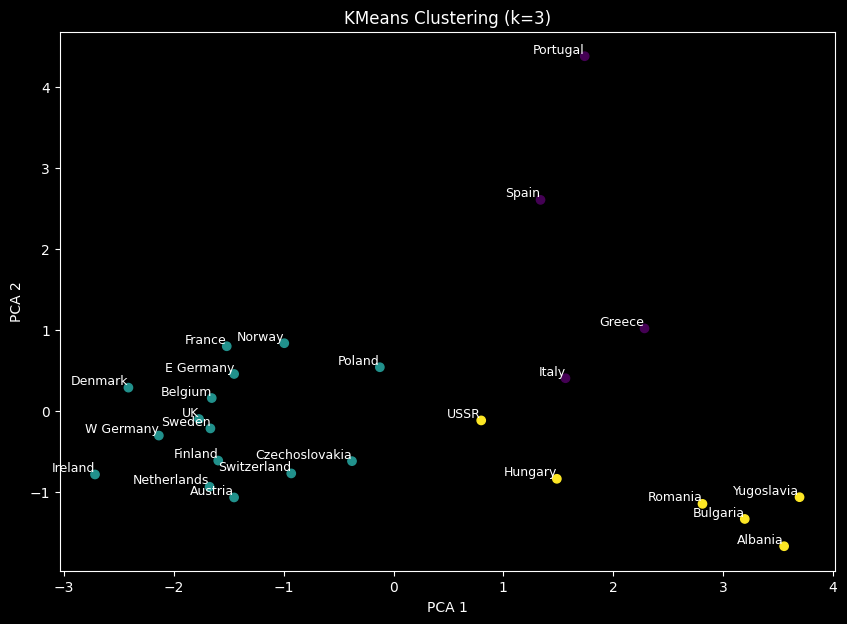

In [12]:
#Visualize Clusters with PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_model.labels_, cmap='viridis')


# Create a DataFrame for PCA results
X_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

X_pca['Country'] = countries  # Add countries

# Write country names in the plot [Note AI: ChatGPT helped me to find a solution to add country names]
for i, country in enumerate(X_pca['Country']):
    plt.text(X_pca['PC1'][i], X_pca['PC2'][i], country, fontsize=9, ha='right', va='bottom')



plt.title(f"KMeans Clustering (k={best_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [19]:
# Loadings = Influence of the original features on PCA 1 and PCA 2

loadings = pd.DataFrame(
    pca.components_.T,  # transpose so that each line is a feature
    columns=["PCA 1", "PCA 2"],
    index=df_numeric.columns  # names of the original features
)

print(loadings)

              PCA 1     PCA 2
RedMeat   -0.302609 -0.056252
WhiteMeat -0.310556 -0.236853
Eggs      -0.426679 -0.035336
Milk      -0.377727 -0.184589
Fish      -0.135650  0.646820
Cereals    0.437743 -0.233485
Starch    -0.297248  0.352826
Nuts       0.420334  0.143311
Fr.Veg     0.110420  0.536190


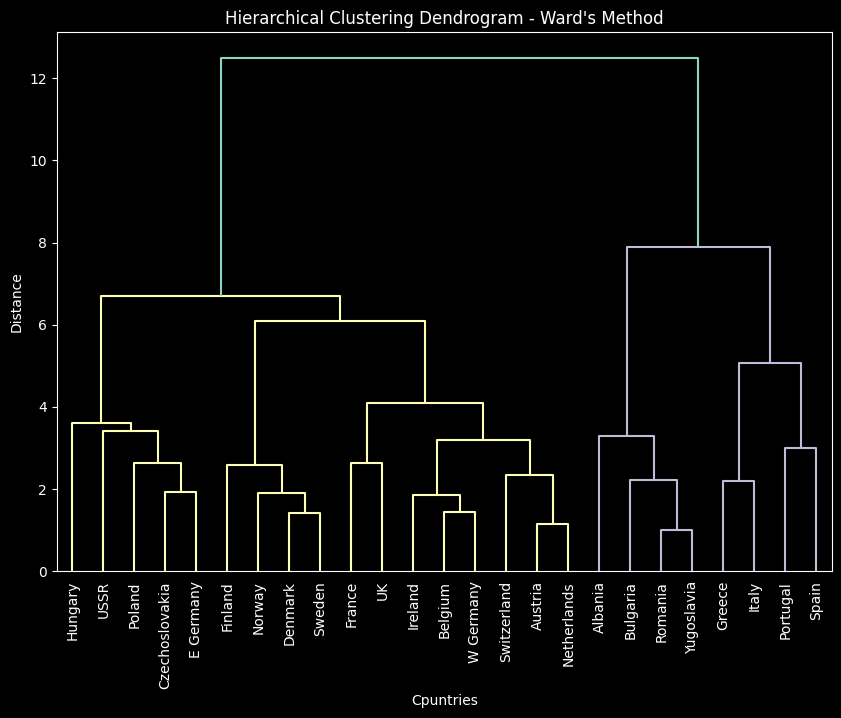

In [ ]:
# Perform Hierarchical Clustering and Dendrogramm

from scipy.cluster.hierarchy import linkage, dendrogram



linked = linkage(scaled_data, method='ward')

# countris as labels for y-axis
labels = countries.tolist()

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=labels, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram - Ward's Method")
plt.xlabel("Cpuntries")
plt.ylabel("Distance")
plt.show()


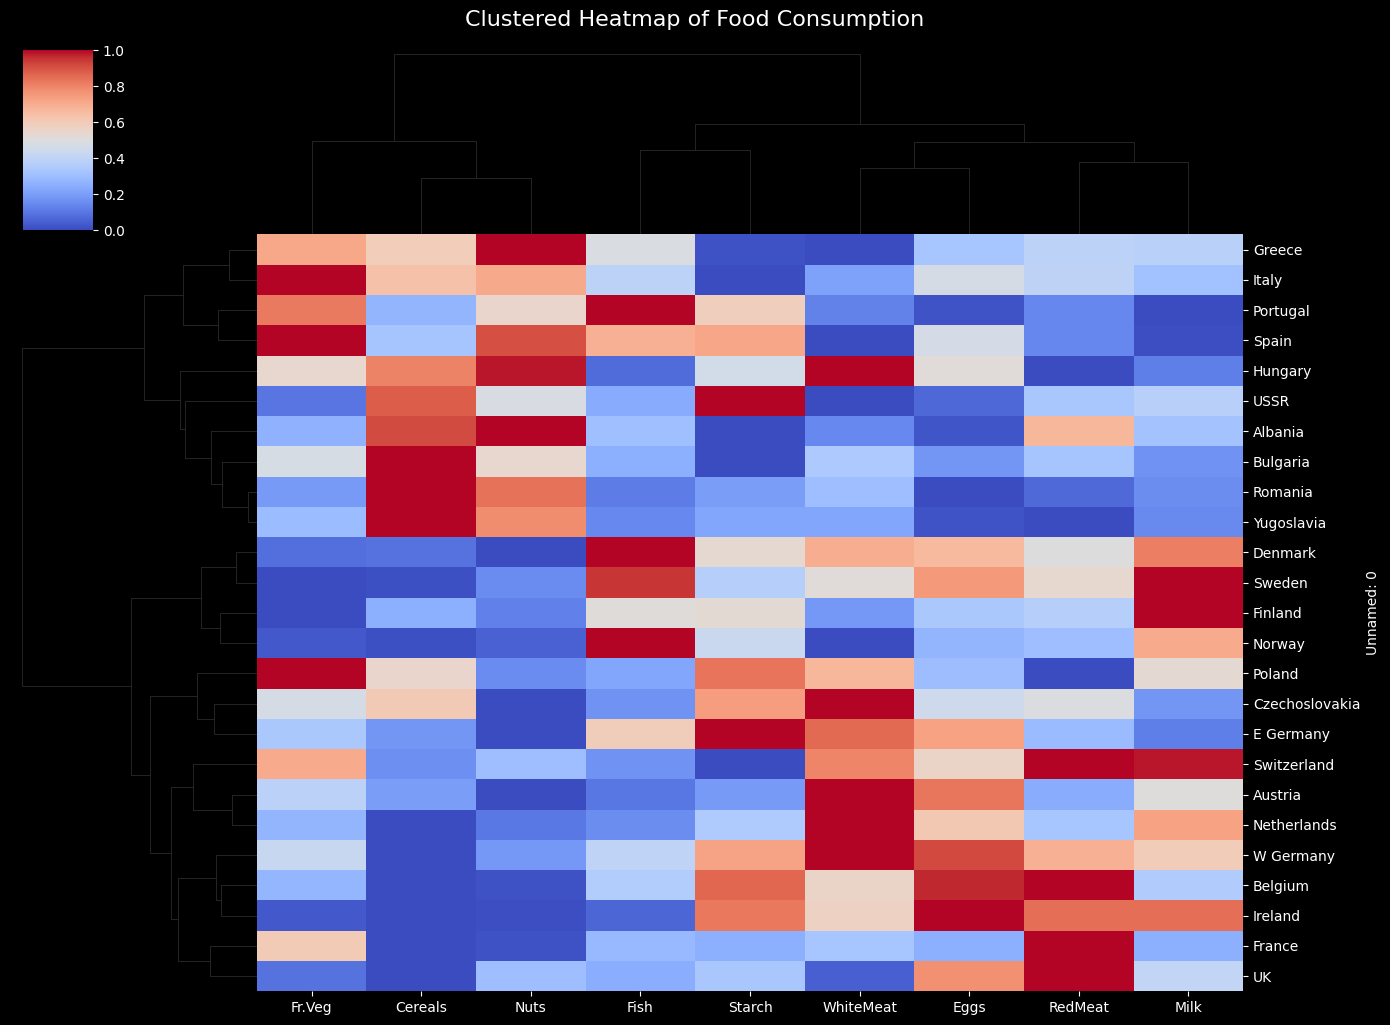

In [ ]:
# Set index to countries 
scaled_data = pd.DataFrame(scaled_data, index=countries, columns=df.columns[1:])

# Clustered heatmap erstellen

import seaborn as sns
sns.clustermap(
    scaled_data,
    method='ward',
    cmap='coolwarm',
    standard_scale=0,  # 0 -> already done
    figsize=(14, 10),
    xticklabels=True,
    yticklabels=True
)

plt.suptitle('Clustered Heatmap of Food Consumption', fontsize=16, y=1.02)
plt.show()

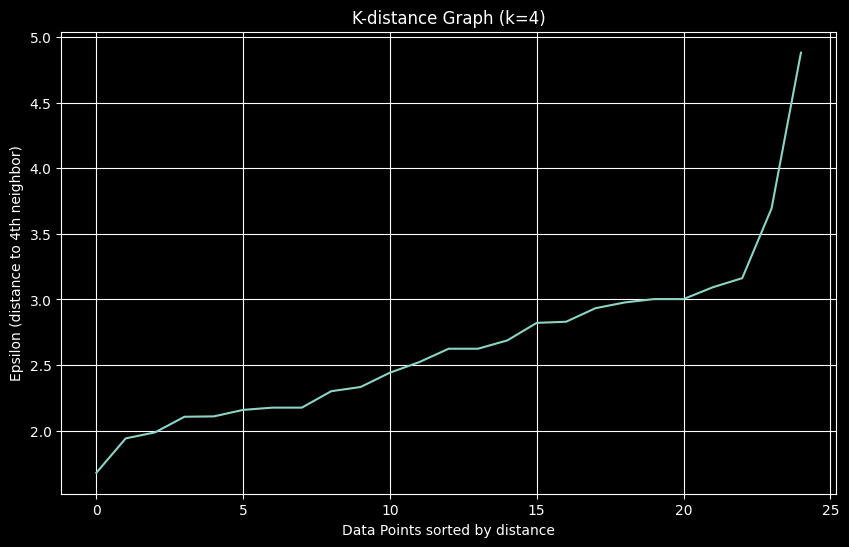

In [ ]:
# Find optimal eps value for DBSCAN using the k-distance graph (elbow method)
#This was also shown to me by Andre Schomakers

from sklearn.neighbors import NearestNeighbors

k = 4  # number of neighbors to consider
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(scaled_data)

# Get distances to k-th nearest neighbor
distances, indices = neigh.kneighbors(scaled_data)
distances = np.sort(distances[:, k-1])  # sort the distances to the 4th neighbor

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'Epsilon (distance to {k}th neighbor)')
plt.grid(True)
plt.show()

# The sharp rise seems to start around index 21–22
# the corresponding y-value (epsilon) there is about 3.0
# So everything below 3.0 is in tighter groups, above that we start hitting outliers



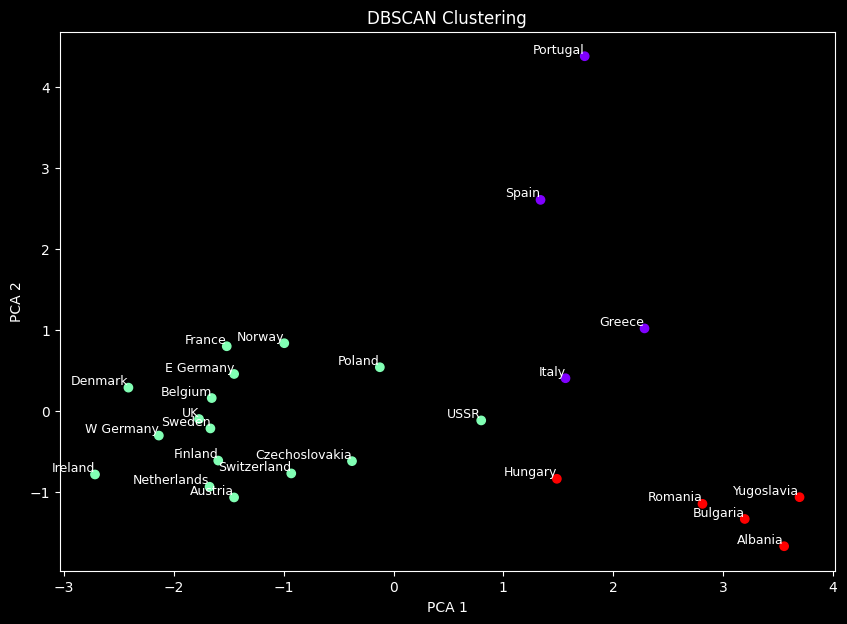

In [ ]:
# Perform density-based clustering (DBSCAN) and visualize the clusters using PCA-reduced 2D data

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.8, min_samples=4) 
db_labels = dbscan.fit_predict(scaled_data)
plt.figure(figsize=(10, 7))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=db_labels, cmap='rainbow')


for i, country in enumerate(X_pca['Country']):
    plt.text(X_pca['PC1'][i], X_pca['PC2'][i], country, fontsize=9, ha='right', va='bottom')


plt.title("DBSCAN Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
